In [1]:
import pandas
from pandas.io.json import json_normalize
import matplotlib
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
df = pandas.read_json('/mnt/c/Code/cancer-survival-rates/data/processed/case_studies_clean.json')

In [3]:
cleaned = df.loc[(df['major_site'] != 'Other') & ~df['ethnicity'].isin(['not reported']) & ~df['race'].isin(['not reported', 'Unknown', 'unknown', 'not allowed to collect']) & ~df['gender'].isin(['not reported', 'unknown'])].dropna(subset=['race', 'major_site', 'ethnicity', 'gender'])

In [4]:
cleaned['major_site'].value_counts()

Lung              6930
Breast            5145
Colorectoral      4771
Nervous system    2356
Ovary             1958
Kidney            1954
Skin              1672
Uterus            1560
Pancreas          1494
Prostate          1279
Bladder           1013
Liver              953
Soft tissue        907
Thyroid            850
Esophagus          795
Stomach            770
Brain              756
Head and neck      708
Adrenal gland      499
Bone               417
Cervix             403
Lymph nodes        328
Testis             309
Thymus             179
Eye                125
Blood                1
Name: major_site, dtype: int64

In [11]:
cleaned['is_breast'] = cleaned['major_site'].apply(lambda x: (1 if x == 'Breast' else 0))

In [19]:
shuffled = cleaned.reindex(np.random.permutation(cleaned.index))

In [31]:
def split_shuffled(dataset, percent):
    split_on = int(len(dataset) * percent)
    specified_size = dataset.head(split_on)
    the_rest = dataset[split_on:]
    return specified_size, the_rest

# going with a simple vocab list since the number of potential values in each of our feature columns is pretty low
def make_one_hot(source_set, column):
    return tf.feature_column.categorical_column_with_vocabulary_list(column, source_set.dropna(subset=[column])[column].unique().tolist())

def construct_feature_columns():
    race = make_one_hot(cleaned, 'race')
    gender = make_one_hot(cleaned, 'gender')
    ethnicity = make_one_hot(cleaned, 'ethnicity')
    return [race, gender, ethnicity]

def preprocess(dataframe):
    selected_features = dataframe[['gender', 'race', 'ethnicity']]
    selected_labels = dataframe['is_breast']
    return selected_features.copy(), selected_labels.copy()

In [32]:
feature_columns = construct_feature_columns()

In [9]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

In [20]:
train, test = split_shuffled(shuffled, 0.8)
train, val = split_shuffled(train, 0.8)

In [21]:
training_features, training_labels = preprocess(train)
validation_features, validation_labels = preprocess(val)

In [23]:
ds = make_input_fn(training_features, training_labels, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['gender'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['gender', 'race', 'ethnicity']

A batch of class: [b'female' b'female' b'male' b'female' b'female' b'male' b'male' b'male'
 b'female' b'female']

A batch of Labels: [0 1 1 0 0 0 0 0 0 0]


In [33]:
train_input_fn = make_input_fn(training_features, training_labels)
eval_input_fn = make_input_fn(validation_features, validation_labels)

In [30]:
gender_column = list(construct_feature_columns())[1]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [44]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

print(result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2vfj2tds', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [36]:
all_cross_column = tf.feature_column.crossed_column(['race', 'ethnicity', 'gender'], hash_bucket_size=100)
background_column = tf.feature_column.crossed_column(['race', 'ethnicity'], hash_bucket_size=100)
derived_columns = [all_cross_column, background_column]

In [39]:
def learn_machine(train_fn, eval_fn, columns):
    liner_est = tf.estimator.LinearClassifier(feature_columns=columns)
    liner_est.train(train_fn)
    reslt = liner_est.evaluate(eval_fn)

    print(reslt)


In [40]:
learn_machine(train_input_fn, eval_input_fn, feature_columns + derived_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9hs5hh_f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp2vfj2tds/model.ckpt-7630
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


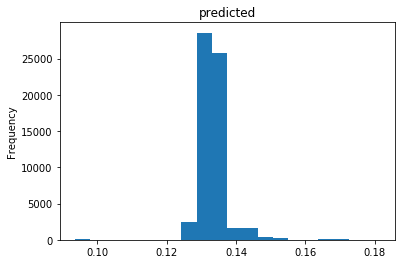

In [45]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pandas.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted')

In [47]:
len(probs)

61010

In [46]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as pyplot

fpr, tpf, _ = roc_curve(validation_labels, probs)
plt.plot(fpr, tpf)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

ValueError: Found input variables with inconsistent numbers of samples: [6101, 61010]